In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sys
import os
import glob
import datetime
from scipy import stats
import gsw
import matplotlib
from AutoBOD_processing import calc_airsat_o2_conc, bottle_add_data, standardize_Nobs, datetime_from_date_hour, autobod_processing
matplotlib.rcParams.update({'font.size': 15})

### AutoBOD processing

Whenever the AutoBOD is reset (turned off and on again), it initializes from a preset date. For the Calypso 2022 cruise, that was Jan. 1, 2022. We can get a relative elapsed time by subtracting this start date from the date recorded by the AutoBOD

In [2]:
autoBOD_start_date = datetime.datetime(2022, 1, 1)

We need to provide the directory where all the logs from the AutoBOD are stored. In addition, we provide the location of a CSV that connects the AutoBOD log data and locations of all bottles to the relevant metadata. An example CSV is provided in the GitHub repository. 

In [3]:
# Location of log files from AutoBOD

log_dir = '../logs/AutoBOD_logs/'

# Location of metadata CSV
log_sheet = pd.read_csv('../logs/AutoBOD_digital_log_sheet.csv')

In [4]:
log_sheet.head()

,Bottle,Bottle_ID,Cast_Niskin,Logfile,AutoBOD_start_time_UTC,Depth,Notes
0,1,C1N11_2,C1N11,C001_021822_autoBOD.log,2/18/22 14:35,525,NaN
1,2,C1N7_2,C1N7,C001_021822_autoBOD.log,2/18/22 14:35,300,NaN
2,3,C1N3_1,C1N3,C001_021822_autoBOD.log,2/18/22 14:35,73,NaN
3,4,C1N3_2,C1N3,C001_021822_autoBOD.log,2/18/22 14:35,73,NaN
4,5,C1N5_1,C1N5,C001_021822_autoBOD.log,2/18/22 14:35,188,NaN


In [5]:
master_ds = autobod_processing(log_dir, log_sheet, autoBOD_start_date, logging_on=True)

C001_021822_autoBOD-1.log
C001_021822_autoBOD.log
C002_021922_autoBOD.log
Run003_022122_autoBOD.log
Run004_022122_autoBOD.log
Run005_022122_autoBOD.log
Run006_022222_autoBOD.log
Run007_022322_autoBOD.log
Run008_022322_autoBOD.log
Run009_022322_autoBOD.log
Run010_022322_autoBOD.log
Run011_022322_autoBOD.log
Run012_022322_autoBOD.log
Run013_022422_autoBOD.log
Run014_022422_autoBOD.log
Run015_022522_autoBOD.log
Run016_022522_autoBOD.log
Run017_022522_autoBOD.log
Run018_022622_autoBOD.log
Run019_022622_autoBOD.log
Run020_022622_autoBOD.log
Run021_022622_autoBOD.log
Run022_022722_autoBOD.log
Run023_022722_autoBOD.log
Run024_022722_autoBOD.log
Run025_022722_autoBOD.log
Run026_022822_autoBOD.log
Run027_022822_autoBOD.log
Run028_022822_autoBOD.log
Run029_022822_autoBOD.log
Run030_030122_autoBOD.log
Run031_030122_autoBOD.log
Run032_030122_autoBOD.log
Run033_030122_autoBOD.log
Run034_030222_autoBOD.log
Run035_030322_autoBOD.log
Run036_030322_autoBOD.log
Run037_030322_autoBOD.log
Run038_030322_au

In [17]:
master_ds.to_netcdf('autoBOD_respiration_rates.nc')

### Look at some plotted timeseries of oxygen concentration from different samples and do back-of-the envelope calculation of respiration rates 
Mostly to make sure code above works! Stay tuned for a bootstrapped approach to estimate respiration rates from all data poitns

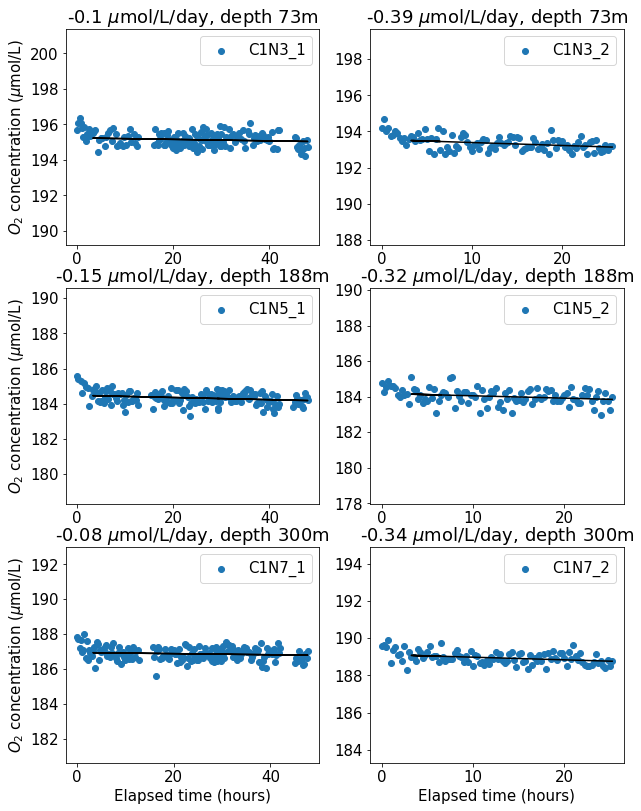

In [12]:
ids = ['C1N3', 'C1N5', 'C1N7']
    
fig, axes = plt.subplots(len(ids), 2, figsize = (10,4.5*len(ids)))

for j, val in enumerate(ids):
    
    for i in range(2):
        bid = val + '_' + str(i+1)
        test = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)
        test['time_float'] = test.UTC_datetime.astype('float')
        grpby = test.to_dataframe().groupby('measurement_number').agg({'O2_conc_umol_L': np.nanmedian,
                                            'IRBotT': np.nanmedian, 'time_float': np.nanmedian})

        axis_time = grpby.time_float.values - np.nanmin(grpby.time_float.values)
        axes[j, i].scatter(axis_time/(1e9*60*60), grpby.O2_conc_umol_L, label=bid)
        
        #Try to fit a polyline
        remove_outliers = True
        start_point = 3 #starting at 3 hours from collecting the bottle sample
        
        polyfit_resp_rates = []
        time_vals = axis_time/(1e9*60*60)
        time_ind = time_vals >= start_point
        time_vals = time_vals[time_ind]
        o2_vals = grpby.O2_conc_umol_L.values
        o2_vals = o2_vals[time_ind]
        nan_ind = ~np.isnan(o2_vals)

        #Remove outliers, i.e. with a zcore 
        if remove_outliers:
            outlier_ind = (np.abs(stats.zscore(o2_vals[nan_ind])) < 3)
        else:
            outlier_ind = np.ones(len(o2_vals[nan_ind])).astype('bool')
        p = np.polyfit(time_vals[nan_ind][outlier_ind], o2_vals[nan_ind][outlier_ind], deg=1)
        polyfit_resp_rates.append(p[0])
        #p = np.polyfit(time_vals[nan_ind], np.log(o2_vals)[nan_ind], deg=1)
        
        axes[j, i].plot(time_vals[nan_ind], p[0]*time_vals[nan_ind] + p[1], color='black')
        
        if j == len(ids) - 1:
            axes[j, i].set_xlabel('Elapsed time (hours)')
        if i == 0:
            axes[j, i].set_ylabel(r'$O_2$ concentration ($\mu$mol/L)')

        
        axes[j, i].set_ylim(np.nanmin(grpby.O2_conc_umol_L.values) - 5, 
                         np.nanmax(grpby.O2_conc_umol_L.values) + 5)

        axes[j, i].legend()
        
        axes[j, i].set_title(str(np.round(p[0]*24, 2)) + r' $\mu$mol/L/day' +\
                          ', depth '+ str(test.Depth.values[0]) + 'm')
        
        np.round(p[0]*24, 2)
